### Enforcing Fairness in Computer Vision

This code demonstrates how to enforce fairness when working with deep neural networks in computer vision. 

We demonstrate how different notions of fairness and performance can be measured and enforced with our toolkit. 

We recommend you first try  [quickstart_xgboost.ipynb](quickstart_xgboost.ipynb) notebook for an introduction to the toolkit's functionality. 

We first show an example on [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The protected groups are given by the labels for the attribute `Male`. You can specify which target attribute (e.g., Wearing_Earrings) you want to enforce fairness for. 
You can also specify which fairness and performance metrics to measure.

At the end of the notebook, we look at an example using medical data from [Fitzpatrick-17k](https://arxiv.org/pdf/2104.09957).

Input Requirements: 

1. We need the validation and test labels for the protected and target attributes.
2. We also require the model outputs. These will typically be logits for the target attribute and probabilities for the inferred protected attribute. It is also possible to use the true group labels (non-inferred). This data used in this notebook demonstration is fetched from an anonymous repository.

We use DeepFairPredictor (recommended), which is optimized for deep learning classifiers. 

For more details about the theory, check out this [paper](https://arxiv.org/pdf/2203.04913) for theoretically explanations into why the majority of fairness methods designed for low capacity models should not be used in settings involving high-capacity models and this [paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/698c05933e5f7fde98e567a669d2c752-Paper-Conference.pdf) for more details on the two/multi- headed approach for a post-processing approach to enforce fairness with validation data when working with deep learning models.  

For an explicit example showing how to merge the two heads, see [here](./pytorch_minimal_demo.ipynb).


In [1]:
import numpy as np 
import oxonfair
from oxonfair.utils import group_metrics as gm
from matplotlib import pyplot as plt
import requests
import io

As the files associated with pre-trained deep learning models can be quite large, we start by defining a function that can extract model outputs and labels from a URL.

In [2]:
# Define a function that takes variable names and URLs, and returns a dictionary of data
def fetch_data_with_labels(variable_names, urls):
    if len(variable_names) != len(urls):
        raise ValueError("The number of variable names and URLs must be the same.")

    # Create a mapping between variable names and URLs
    label_url_mapping = dict(zip(variable_names, urls))
    fetched_data = {}

    # Loop through the dictionary to fetch data
    for label, url in label_url_mapping.items():
        try:
            # Fetch the data from the URL
            response = requests.get(url)
            response.raise_for_status()  # Check if the request was successful

            # Load the data with numpy
            data = np.load(io.BytesIO(response.content))

            # Store the data in the dictionary with the given label
            fetched_data[label] = data

        except requests.exceptions.RequestException as e:
            # Handle request errors (network issues, invalid URL, etc.)
            print(f"Error fetching '{label}' from '{url}': {e}")

        except Exception as e:
            # Handle other exceptions (e.g., issues with loading data, numpy errors, etc.)
            print(f"Error processing '{label}' from '{url}': {e}")

    return fetched_data

In [3]:
variable_names_celeba = ['validation_labels', 'test_labels', 'validation_outputs', 'test_outputs']

url_data_celeba = ['https://anonymous.4open.science/r/example_data_fairness-15BA/all_attributes_val_labels.npy',
    'https://anonymous.4open.science/r/example_data_fairness-15BA/all_attributes_test_labels.npy',
    'https://anonymous.4open.science/r/example_data_fairness-15BA/All_Attributes_outputs_val.npy',
    'https://anonymous.4open.science/r/example_data_fairness-15BA/All_Attributes_outputs_test.npy']

In [4]:
fetched_data = fetch_data_with_labels(variable_names=variable_names_celeba, urls=url_data_celeba)

In [5]:
validation_labels = fetched_data['validation_labels'] #loading the validation labels for all attributes
test_labels = fetched_data['test_labels'] #loading the test labels for all attributes
validation_outputs = fetched_data['validation_outputs'] # loading the corresponding validation outputs 
test_outputs = fetched_data['test_outputs'] # loading the corresponding validation outputs

In [6]:
def get_all_celeba_attributes():
    return ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips',
            'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
            'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
            'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
            'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
            'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
            'Wearing_Necktie', 'Young']

In [7]:
np.column_stack((validation_outputs[:,34], validation_outputs[:,20])) #Outputs for Wearing_Earrings and Male

array([[-3.72390795, -0.04863382],
       [-6.71334314,  1.003914  ],
       [-5.54749012,  0.01078447],
       ...,
       [-1.99252629, -0.03643667],
       [ 0.69160038, -0.02428942],
       [-4.78321409,  0.98419327]])

(array([4.000e+00, 8.000e+00, 1.800e+01, 8.900e+01, 2.570e+02, 6.700e+02,
        1.345e+03, 1.897e+03, 2.128e+03, 1.857e+03, 1.278e+03, 7.590e+02,
        3.940e+02, 1.850e+02, 1.280e+02, 6.500e+01, 4.100e+01, 3.400e+01,
        2.600e+01, 1.800e+01, 1.500e+01, 2.500e+01, 1.700e+01, 1.000e+01,
        1.400e+01, 7.000e+00, 1.500e+01, 9.000e+00, 6.000e+00, 8.000e+00,
        9.000e+00, 4.000e+00, 3.000e+00, 7.000e+00, 6.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 6.000e+00, 3.000e+00,
        7.000e+00, 8.000e+00, 0.000e+00, 5.000e+00, 8.000e+00, 6.000e+00,
        7.000e+00, 4.000e+00, 7.000e+00, 8.000e+00, 6.000e+00, 4.000e+00,
        9.000e+00, 6.000e+00, 7.000e+00, 1.000e+00, 5.000e+00, 7.000e+00,
        6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 6.000e+00,
        1.200e+01, 9.000e+00, 1.600e+01, 1.300e+01, 9.000e+00, 1.000e+01,
        1.200e+01, 2.000e+01, 2.800e+01, 2.200e+01, 3.300e+01, 4.000e+01,
        5.800e+01, 1.090e+02, 1.510e+0

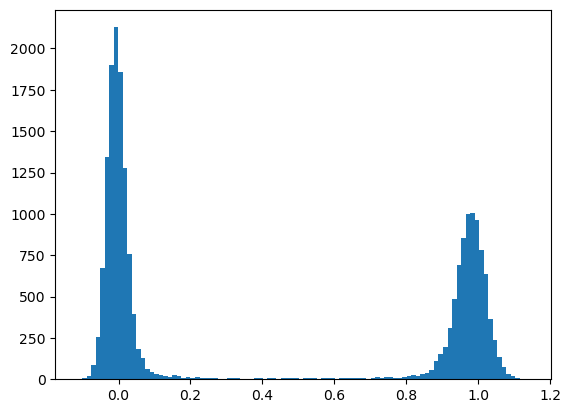

In [8]:
plt.hist((validation_outputs[:,20]), bins=100) # just looking at the outputs from the protected head. The bi-modal peak indicates good seperation between groups. 

In [9]:
protected_attribute_index = get_all_celeba_attributes().index('Male')
target_attribute_index = get_all_celeba_attributes().index('Wearing_Earrings')

In [10]:
val = np.column_stack((validation_outputs[:,target_attribute_index], validation_outputs[:,20]))
val_target = validation_labels[:,target_attribute_index]
val_groups = validation_labels[:,protected_attribute_index]

test = np.column_stack((test_outputs[:,target_attribute_index], test_outputs[:,20]))
test_target = test_labels[:,target_attribute_index]
test_groups = test_labels[:,protected_attribute_index]

In [11]:
val_dict={'data':val, 'target':val_target, 'groups':val_groups}
test_dict={'data':test,'target':test_target,'groups':test_groups}

### Enforcing Fairness with DeepFairPredictor

In [12]:
fpred = oxonfair.DeepFairPredictor(val_target,val,val_groups, use_actual_groups=False) 
# if use_actual_groups=True this will assign thresholds using the provided groups rather than the output of the second head 

In [13]:
fpred.fit(gm.accuracy,gm.equal_opportunity,0.01)
# this can be changed to different definitions of fairness --- fpred.fit(gm.accuracy,gm.recall.min,0.8)

In [14]:
fpred.evaluate(test_dict)

,original,updated
Accuracy,0.910380,0.901062
Balanced Accuracy,0.853250,0.826761
F1 score,0.777072,0.745194
MCC,0.721488,0.686312
Precision,0.799487,0.796470
Recall,0.755879,0.700121
ROC AUC,0.956715,0.946070


In [15]:
fpred.evaluate_groups(return_original=True) #on val

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.924800           0.861855  0.794045  0.749278   
         0                   0.878429           0.852288  0.805169  0.717852   
         1                   0.987349           0.564036  0.207407  0.254912   
         Maximum difference  0.108920           0.288252  0.597762  0.462940   
updated  Overall             0.914481           0.829861  0.755575  0.708492   
         0                   0.870015           0.823741  0.774860  0.694721   
         1                   0.974462           0.831694  0.406593  0.434754   
         Maximum difference  0.104447           0.007953  0.368266  0.259967   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.831169  0.760095  0.965498          3789.0   
         0                    0.833624  0.778593  0.940365          3681.0   
         1                    0.518519  0.129630  0.960154           108.0   
         Maximum difference   0.315106  0.648963  0.019789          3573.0   
updated  Overall              0.830487  0.693059  0.953978          3789.0   
         0                    0.878183  0.693290  0.940512          3681.0   
         1                    0.289062  0.685185  0.961986           108.0   
         Maximum difference   0.589121  0.008105  0.021474          3573.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                    16078.0             0.190718   
         0                           7728.0             0.322640   
         1                           8350.0             0.012769   
         Maximum difference           622.0             0.309871   
updated  Overall                    16078.0             0.190718   
         0                           7728.0             0.322640   
         1                           8350.0             0.012769   
         Maximum difference           622.0             0.309871   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.174410  
         0                                   0.301341  
         1                                   0.003192  
         Maximum difference                  0.298149  
updated  Overall                             0.159158  
         0                                   0.254711  
         1                                   0.030267  
         Maximum difference                  0.224444

In [16]:
fpred.evaluate_groups(test_dict,return_original=True) #on the test set

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.910380           0.853250  0.777072  0.721488   
         0                   0.866498           0.843349  0.789657  0.692062   
         1                   0.980039           0.633222  0.388889  0.426468   
         Maximum difference  0.113541           0.210128  0.400768  0.265595   
updated  Overall             0.901062           0.826761  0.745194  0.686312   
         0                   0.861435           0.818905  0.764730  0.673611   
         1                   0.963966           0.842142  0.483271  0.495019   
         Maximum difference  0.102531           0.023237  0.281459  0.178592   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.799487  0.755879  0.956715          4125.0   
         0                    0.801305  0.778341  0.931490          3943.0   
         1                    0.700000  0.269231  0.969253           182.0   
         Maximum difference   0.101305  0.509111  0.037764          3761.0   
updated  Overall              0.796470  0.700121  0.946070          4125.0   
         0                    0.843425  0.699467  0.931252          3943.0   
         1                    0.365169  0.714286  0.968197           182.0   
         Maximum difference   0.478257  0.014818  0.036945          3761.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                    15837.0             0.206643   
         0                           8304.0             0.321956   
         1                           7533.0             0.023590   
         Maximum difference           771.0             0.298366   
updated  Overall                    15837.0             0.206643   
         0                           8304.0             0.321956   
         1                           7533.0             0.023590   
         Maximum difference           771.0             0.298366   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.195371  
         0                                   0.312730  
         1                                   0.009073  
         Maximum difference                  0.303656  
updated  Overall                             0.181645  
         0                                   0.267004  
         1                                   0.046144  
         Maximum difference                  0.220860

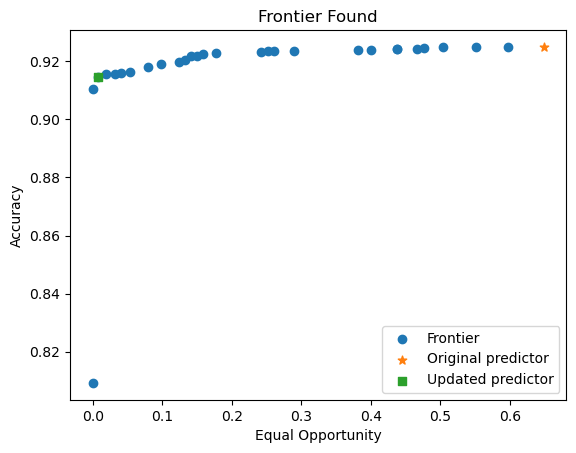

In [17]:
figure = fpred.plot_frontier() #looking at the frontier on the validation set

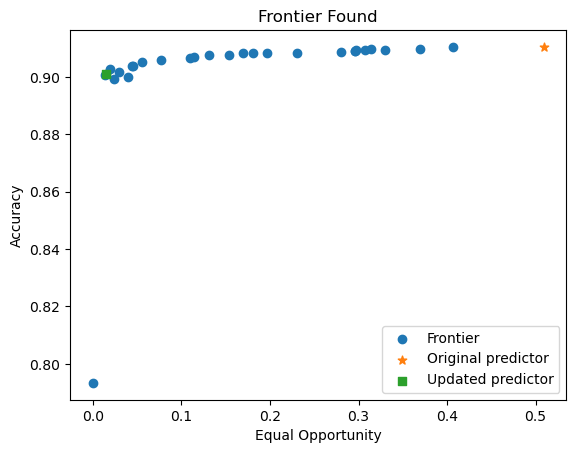

In [18]:
fpred.plot_frontier(test_dict) # viewing performance on the test set. 

In [19]:
fpred.evaluate_fairness(test_dict)

,original,updated
Statistical Parity,0.303656,0.220860
Predictive Parity,0.101305,0.478257
Equal Opportunity,0.509111,0.014818
Average Group Difference in False Negative Rate,0.509111,0.014818
Equalized Odds,0.298983,0.023237
Conditional Use Accuracy,0.093873,0.301597
Average Group Difference in Accuracy,0.113541,0.102531
Treatment Equality,0.712815,3.914086


In [20]:
fpred.evaluate_fairness(metrics={'min_acc':gm.min_accuracy.min,'accuracy':gm.accuracy}) #you can specify what metrics you care about

,original,updated
Minimal Group Minimum-Label-Accuracy,0.12963,0.685185
Accuracy,0.92480,0.914481


In [21]:
fpred.evaluate_fairness(test_dict,metrics={'min_acc':gm.min_accuracy.min,'accuracy':gm.accuracy})

,original,updated
Minimal Group Minimum-Label-Accuracy,0.269231,0.699467
Accuracy,0.910380,0.901062


### Fitzpatrick-17k Example

Next we demonstrate how our toolkit could be used with medical data. The implementation details will be similar, but practitioners may want to think carefully about how they measure and enforce fairness in high stakes domains. We recommend a harms-first approach emphasizing metrics such as per group recall or selection rate. 

Here the target label classifies if a skin condition is malignant or benign. The protected label indicates race. Data is preprocessed following the description and code of [Zong et al.](https://arxiv.org/pdf/2210.01725) 

In [22]:
variable_names_fitz17k = ['fitz_outputs_val', 'fitz_outputs_test', 'fitz_target_labels_val',
                           'fitz_protected_labels_val', 'fitz_target_labels_test', 'fitz_protected_labels_test']

In [23]:
url_fitz17k = ['https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_balanced_outputs_val_fitz17k.npy',
               'https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_balanced_outputs_test_fitz17k.npy',
               'https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_fitz17k_target_labels_val.npy',
               'https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_fitz17k_protected_labels_val.npy',
               'https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_fitz17k_target_labels_test.npy',
               'https://anonymous.4open.science/r/example_data_fairness-15BA/60_20_20_1_fitz17k_protected_labels_test.npy'
               ]

In [24]:
fitz_data = fetch_data_with_labels(variable_names_fitz17k, url_fitz17k)

In [25]:
fitz_data['fitz_outputs_val']

array([[ 0.79199237,  0.37575418],
       [-2.51230526,  0.70082897],
       [-4.45861387,  0.61371773],
       ...,
       [ 1.30813837,  0.23435649],
       [-2.95502949,  0.38634309],
       [-3.13313341,  0.14978038]])

In [26]:
fitz_outputs_val = fitz_data['fitz_outputs_val']
fitz_outputs_test = fitz_data['fitz_outputs_test']
fitz_target_labels_val = fitz_data['fitz_target_labels_val']
fitz_protected_labels_val = fitz_data['fitz_protected_labels_val']
fitz_target_labels_test = fitz_data['fitz_target_labels_test']
fitz_protected_labels_test = fitz_data['fitz_protected_labels_test']

In [27]:
val_dict_fitz={'data':fitz_outputs_val, 'target':fitz_target_labels_val, 'groups':fitz_protected_labels_val}
test_dict_fitz={'data':fitz_outputs_test,'target':fitz_target_labels_test,'groups':fitz_protected_labels_test}

In [28]:
fpred_fitz = oxonfair.DeepFairPredictor(fitz_target_labels_val,fitz_outputs_val,fitz_protected_labels_val)

In [29]:
fpred_fitz.fit(gm.accuracy,gm.recall.min,0.7)

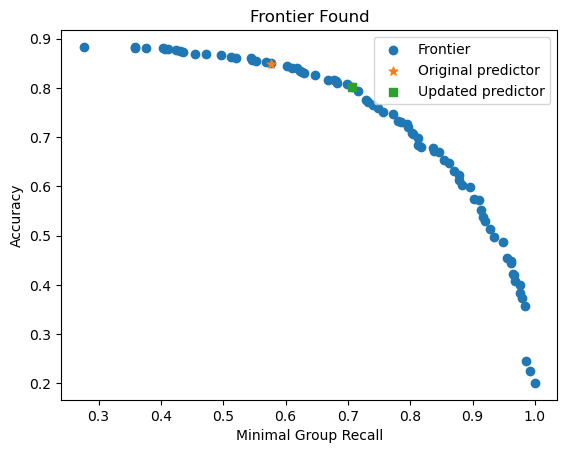

In [30]:
fpred_fitz.plot_frontier() #looking at the frontier on the validation set

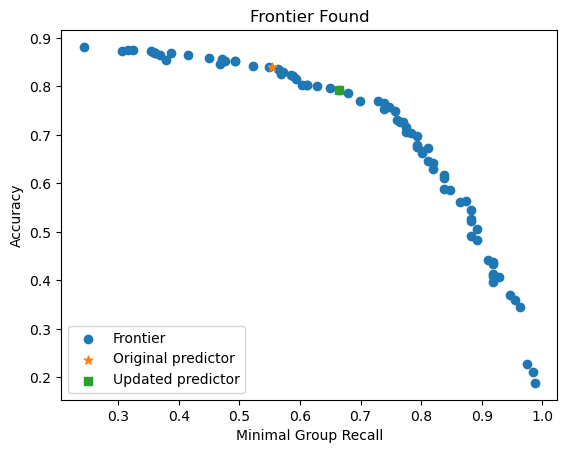

In [31]:
fpred_fitz.plot_frontier(test_dict_fitz) #looking at the frontier on the validation set

In [32]:
fpred_fitz.evaluate_groups(test_dict_fitz) #looking at the group breakdown on test data. 

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.839023           0.720454  0.486000  0.396986   
         0.0                 0.816804           0.708386  0.474308  0.371757   
         1.0                 0.886700           0.746726  0.522822  0.460837   
         Maximum difference  0.069895           0.038341  0.048513  0.089081   
updated  Overall             0.792358           0.739773  0.467470  0.378586   
         0.0                 0.776400           0.730311  0.470076  0.368513   
         1.0                 0.826601           0.760404  0.460123  0.397795   
         Maximum difference  0.050201           0.030093  0.009953  0.029282   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.430851  0.557339  0.824450           436.0   
         0.0                  0.414747  0.553846  0.813847           325.0   
         1.0                  0.484615  0.567568  0.840469           111.0   
         Maximum difference   0.069869  0.013721  0.026622           214.0   
updated  Overall              0.359703  0.667431  0.819707           436.0   
         0.0                  0.363636  0.664615  0.812675           325.0   
         1.0                  0.348837  0.675676  0.830374           111.0   
         Maximum difference   0.014799  0.011060  0.017699           214.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     2757.0             0.136549   
         0.0                         1853.0             0.149219   
         1.0                          904.0             0.109360   
         Maximum difference           949.0             0.039860   
updated  Overall                     2757.0             0.136549   
         0.0                         1853.0             0.149219   
         1.0                          904.0             0.109360   
         Maximum difference           949.0             0.039860   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.176636  
         0.0                                 0.199265  
         1.0                                 0.128079  
         Maximum difference                  0.071187  
updated  Overall                             0.253367  
         0.0                                 0.272727  
         1.0                                 0.211823  
         Maximum difference                  0.060905